<a href="https://colab.research.google.com/github/TouyeAchille/bassa_stt/blob/master/20249198_Binh_TRAN_Nguyen_Thai_Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers "datasets[audio]" accelerate evaluate jiwer ffmpeg-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 76.1 MB/s eta 0:00:00


# Fine-Tuning STT Models for Low-Resource African Languages (Bassa)
In this Deep Learning project, we will focus on fine-tuning a pretrained ASR model to transform Bassa audio to Bassa text. This notebook contains five sections

*   Load dataset
*   Preprocessing
*   Fine-Tuning Pipeline
*   Training Visualization
*   Evaluation Metrics



## Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DATA_DIR = "/content/drive/MyDrive/bassa_stt_tts_data"
TRAIN_DIR = f"{DATA_DIR}/train"
TEST_DIR = f"{DATA_DIR}/test"

MODEL_ID = "openai/whisper-small"
OUTPUT_DIR = "/content/drive/MyDrive/whisper_bassa_finetune"
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

Mounted at /content/drive


Take a look at the csv Bassa text file, we see that 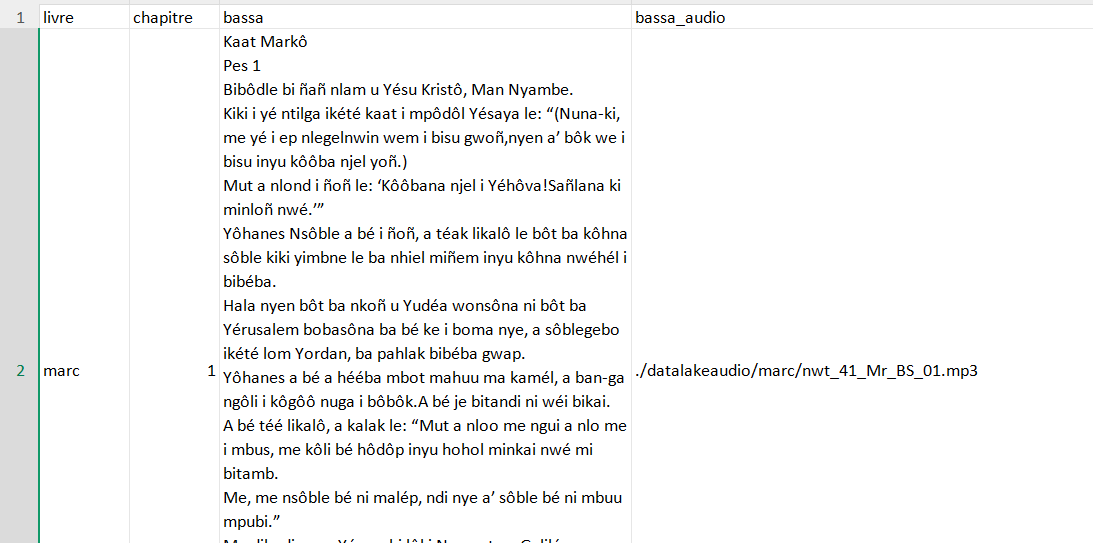

We see that the column value of `bassa_audio` has the url to corresponding mp3 files, but with a different in first part. For example, for the value `./datalakeaudio/marc/nwt_41_Mr_BS_01.mp3`, it should be `audio-marc/nwt_41_Mr_BS_01.mp3`. So, we need to implement a function to convert the link.

In [ ]:
import pandas as pd
import os

# ----------------------------------------------------------
# 2. Helper: Fix the audio url
# ----------------------------------------------------------

def fix_audio_path(path: str):
    """
    Example input:
        './datalakeaudio/marc/nwt_41_Mr_BS_01.mp3'
    Output:
        'audio-marc/nwt_41_Mr_BS_01.mp3'
    """
    filename = os.path.basename(path)

    # Identify folder which is marc / genèse / 1-samuel
    if "marc" in path.lower():
        return os.path.join("audio-marc", filename)
    elif "gen" in path.lower():   # genèse
        return os.path.join("audio-genèse", filename)
    elif "sam" in path.lower():
        return os.path.join("audio-1-samuel", filename)
    else:
        return os.path.join("audio-matthieu", filename)

Now, we will load the csv file, use the function above to fix the url, and combine into dataframe.

In [ ]:
# ----------------------------------------------------------
# 3. Load CSV + Fix the url + Combine into dataframe
# ----------------------------------------------------------

def load_split(split_dir):
    """
    split_dir = TRAIN_DIR or TEST_DIR
    """
    dfs = []
    csv_name_list = []

    if "train" in split_dir:
        csv_name_list = ["marc.csv", "genèse.csv", "1-samuel.csv"]
    elif "test" in split_dir:
        csv_name_list = ["matthieu.csv"]

    for csv_name in csv_name_list:
        csv_path = os.path.join(split_dir, csv_name)

        df = pd.read_csv(csv_path)

        # rename columns for simplification
        df = df.rename(columns={"bassa": "text", "bassa_audio": "audio_path"})

        # Apply the fix audio path function
        df["audio_path"] = df["audio_path"].apply(fix_audio_path)

        # convert audio path to absolute path using lambda function
        df["audio_path"] = df["audio_path"].apply(
            lambda x: os.path.join(split_dir, x)
        )

        dfs.append(df)

    # merge all books
    merged = pd.concat(dfs, ignore_index=True)
    return merged


train_df = load_split(TRAIN_DIR)
test_df = load_split(TEST_DIR)

print("Train size:", len(train_df))
print("Test size:", len(test_df))
train_df.head()

Train size: 97
Test size: 28


,livre,chapitre,text,audio_path
0,marc,1,Kaat Markô\nPes 1\nBibôdle bi ñañ nlam u Yésu ...,/content/drive/MyDrive/bassa_stt_tts_data/trai...
1,marc,2,"Pes 2\nNdi i mbus ndék dilo, a témb a jôp i Ka...",/content/drive/MyDrive/bassa_stt_tts_data/trai...
2,marc,3,Pes 3\nLisañ lipe Yésu a témb a jôp i ndap bib...,/content/drive/MyDrive/bassa_stt_tts_data/trai...
3,marc,4,"Pes 4\nA témb a bôdôl niiga i ngwañ tuye, yak ...",/content/drive/MyDrive/bassa_stt_tts_data/trai...
4,marc,5,"Pes 5\nI mbus, ba pam nyoo uu ngwañ tuye, i nk...",/content/drive/MyDrive/bassa_stt_tts_data/trai...


## Preprocessing
In this part, our activities consist of Audio loading & resampling, Text normalization, Tokenizer & feature extractor preparation.

### Audio loading & resampling
First, we will convert these dataframes to Hugging Face dataset, note that the Whisper feature extractor
 expects audio inputs with a sampling rate of 16kHz, so we need to match our inputs to this value. Hugging Face support to automatically upload audio, which can be viewed in this link https://huggingface.co/docs/datasets/v2.8.0/audio_load

In [ ]:
# ----------------------------------------------------------
# 4. Create HuggingFace Dataset
# ----------------------------------------------------------

from datasets import Dataset, DatasetDict, Audio

train_ds = Dataset.from_pandas(train_df)
test_ds  = Dataset.from_pandas(test_df)

train_ds = train_ds.cast_column("audio_path", Audio(sampling_rate=16000))
test_ds  = test_ds.cast_column("audio_path", Audio(sampling_rate=16000))

dataset = DatasetDict({"train": train_ds, "test": test_ds})

print(dataset["train"][0])

{'livre': 'marc', 'chapitre': 1, 'text': 'Kaat Markô\nPes 1\nBibôdle bi ñañ nlam u Yésu Kristô, Man Nyambe.\nKiki i yé ntilga ikété kaat i mpôdôl Yésaya le: “(Nuna-ki, me yé i ep nlegelnwin wem i bisu gwoñ,nyen a’ bôk we i bisu inyu kôôba njel yoñ.)\nMut a nlond i ñoñ le: ‘Kôôbana njel i Yéhôva!Sañlana ki minloñ nwé.’”\nYôhanes Nsôble a bé i ñoñ, a téak likalô le bôt ba kôhna sôble kiki yimbne le ba nhiel miñem inyu kôhna nwéhél i bibéba.\nHala nyen bôt ba nkoñ u Yudéa wonsôna ni bôt ba Yérusalem bobasôna ba bé ke i boma nye, a sôblegebo ikété lom Yordan, ba pahlak bibéba gwap.\nYôhanes a bé a hééba mbot mahuu ma kamél, a ban-ga ngôli i kôgôô nuga i bôbôk.A bé je bitandi ni wéi bikai.\nA bé téé likalô, a kalak le: “Mut a nloo me ngui a nlo me i mbus, me kôli bé hôdôp inyu hohol minkai nwé mi bitamb.\nMe, me nsôble bé ni malép, ndi nye a’ sôble bé ni mbuu mpubi.”\nMu dilo di nyen Yésu a bi lôl i Nasaret nu Galiléa, Yôhanes a sôble nye ikété Yordan.\nI nlélém ngéda a bé pam ikété malép, 

### Text Normalization

In [ ]:
import re, unicodedata

def normalize_text_bassa(text):
    """
    Normalize Bassa text for ASR:
    - Unicode normalization (NFC)
    - Lowercase conversion
    - Remove newlines and punctuation
    - Normalize whitespace

    Based on the Bassa language characteristics from Cameroon.
    """
    # Unicode normalization (NFC) - important for tone marks
    text = unicodedata.normalize("NFC", text)

    # Lowercase
    text = text.lower()

    # Replace newlines with spaces
    text = text.replace('\n', ' ').replace('\r', ' ')

    # Remove punctuation (but keep tone marks which are part of letters)
    text = re.sub(r"[.,!?;:\"'()\[\]{}«»…\-–—/\\]", " ", text)

    # Normalize multiple spaces to single space
    text = re.sub(r"\s+", " ", text).strip()

    return text

### Tokenizer & feature extractor preparation
The ASR pipeline can be de-composed into three components:
1. A **feature extractor** which pre-processes the raw audio-inputs
2. The **model** which performs the sequence-to-sequence mapping
3. A **tokenizer** which post-processes the model outputs to text format

In Transformers, the Whisper model has an associated feature extractor and tokenizer, called [WhisperFeatureExtractor](https://huggingface.co/docs/transformers/main/model_doc/whisper#transformers.WhisperFeatureExtractor) and [WhisperTokenizer](https://) respectively.

#### Load Whisper Feature Extractor and Tokenizer
- Speech is a continuous 1-D signal (amplitude vs. time); computers require discretization.

- Sampling rate (Hz) defines how often amplitudes are captured; higher rates approximate better but increase storage.

- Matching input sampling rate to the model's expected rate is critical; mismatches distort audio and degrade ASR performance.

- Whisper expects 16kHz audio; wrong rates (e.g., 16kHz played at 8kHz) cause “slow-motion” speech.

- Whisper feature extractor operations:
   - Padding/Truncating: all audio normalized to 30s length; shorter audio will use zero-padding, longer audio will use truncation. No attention mask needed.
   - Log-Mel spectrogram conversion: transforms audio into frequency-time representation; Mel bins approximate human hearing.

**Spectrograms are the actual input format for Whisper fine-tuning**. **Transformers Whisper feature extractor performs both the padding and spectrogram conversion in just one line of code**

In [ ]:
from transformers import WhisperFeatureExtractor, WhisperTokenizer

feature_extractor = WhisperFeatureExtractor.from_pretrained(MODEL_ID, task="transcribe")
tokenizer = WhisperTokenizer.from_pretrained(MODEL_ID, task="transcribe")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

#### Combine To Create A WhisperProcessor
To simplify using the feature extractor and tokenizer, we can wrap both into a single `WhisperProcessor` class. In doing so, we only need to keep track of two objects during training: the `processor` and the `model`

In [ ]:
from transformers import WhisperProcessor
processor = WhisperProcessor.from_pretrained(MODEL_ID, task="transcribe")

#### Prepare Data
Now we can write a function to prepare our data ready for the model:

1. We load and resample the audio data by calling `batch["audio_path"]`. As explained above, Datasets performs any necessary resampling operations on the fly.
2. We use the feature extractor to compute the log-Mel spectrogram input features from our 1-dimensional audio array.
3. We encode the transcriptions to label ids through the use of the tokenizer.

In [ ]:
def prepare_dataset(batch):
    """
    Prepare a batch of data for Whisper training.

    This function:
    1. Extracts audio features using the feature extractor
    2. Normalizes and tokenizes the text
    3. Prepares labels with proper padding
    """
    # Load and process audio
    audio = batch["audio_path"]

    # Compute log-Mel input features from audio array
    batch["input_features"] = feature_extractor(
        audio["array"],
        sampling_rate=audio["sampling_rate"]
    ).input_features[0]

    # Normalize text
    normalized_text = normalize_text_bassa(batch["text"])

    # Encode target text to label ids with truncation
    # Whisper's decoder has a maximum sequence length of 448 tokens
    batch["labels"] = tokenizer(
        normalized_text,
        max_length=448,  # Maximum decoder length for Whisper
        truncation=True,  # Truncate if exceeds max_length
    ).input_ids

    return batch

We can apply the data preparation function to all of our training examples using dataset's `.map` method

In [ ]:
dataset = dataset.map(
    prepare_dataset,
    remove_columns=dataset.column_names["train"],
    num_proc=2
)

print("\nProcessed dataset:")
print(dataset)

Map (num_proc=2):   0%|          | 0/97 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/28 [00:00<?, ? examples/s]


Processed dataset:
DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 97
    })
    test: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 28
    })
})


## Fine Tuning Pipeline


### Load the Pre-Trained Checkpoint

We'll start our fine-tuning run from the pre-trained Whisper  checkpoint, the weights for which we need to load from the Hugging Face Hub.

In [ ]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained(MODEL_ID)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

In [ ]:
import torch

# Set language and task for generation
model.config.use_cache = False
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []
model.enable_input_require_grads()

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### Data Collator

Transformers doesn't have a data collator for ASR, so we need to implement our own data collator. Data Collator for a sequence-to-sequence speech model is unique in the sense that it has

1. **Independent handling**:
 - `input_features` is processed by the feature extractor.
 - `labels` is processed by the tokenizer.

2. **Input features**:
- Already padded to 30s and converted into fixed-dimension log-Mel spectrograms.
- Simply batched into PyTorch tensors using `.pad(return_tensors="pt")`.
- No extra padding required since dimensions are fixed.

3. **Labels**:
 - Initially un-padded; padded to max length in batch via tokenizer's `.pad`.
- Padding tokens replaced with -100, which will be ignored in loss computation.
- Start-of-transcript token removed (it will be appended later during training).

We can leverage the `WhisperProcessor` we defined earlier to perform both the feature extractor and the tokenizer operations

In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor: WhisperProcessor instance
    """
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Split inputs and labels since they have to be of different lengths
        # and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

Let's initialise the data collator we've just defined

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

### Evaluation metrics

Based on the requirement of the project, we will evaluate the training and testing process using two metrics
- **WER**: measures the number of errors made by an ASR model when comparing the
predicted transcription to the correct (reference) transcription.
- **CER**: measures the number of errors at the character level between the predicted text and the correct.

We then simply have to define a function that takes our model predictions and returns the WER metric. This function, called `compute_metrics`, first replaces `-100` with the `pad_token_id` in the `label_ids` (undoing the step we applied in the data collator to ignore padded tokens correctly in the loss). It then decodes the predicted and label ids to strings. Finally, it computes the `WER`, `CER` between the predictions and reference labels

In [ ]:
import evaluate

metric_wer = evaluate.load("wer")
metric_cer = evaluate.load("cer")

def compute_metrics(pred):
    """
    Compute WER (Word Error Rate) and CER (Character Error Rate).
    """
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # Replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # Decode predictions and labels
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    # Compute WER and CER
    wer = 100 * metric_wer.compute(predictions=pred_str, references=label_str)
    cer = 100 * metric_cer.compute(predictions=pred_str, references=label_str)

    return {"wer": wer, "cer": cer}

### Set the training arguments
In the final step, we define all the parameters related to training. A subset of parameters are explained below
- `output_dir`: local directory in which to save the model weights. This will also be the repository name on the Hugging Face Hub.
generation_max_length: maximum number of tokens to autoregressively generate during evaluation.
- `save_steps`: during training, intermediate checkpoints will be saved and uploaded asynchronously to the Hub every save_steps training steps.
eval_steps: during training, evaluation of intermediate checkpoints will be performed every eval_steps training steps.
- `report_to`: where to save training logs.

In [ ]:
from transformers import Seq2SeqTrainingArguments
NUM_EPOCHS = 10
PER_DEVICE_BATCH_SIZE = 16
GRAD_ACCUM_STEPS = 1
LEARNING_RATE = 2e-5

training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,

    # === Batch Configuration ===
    per_device_train_batch_size=PER_DEVICE_BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,

    # === Training Duration ===
    num_train_epochs=NUM_EPOCHS,

    # === Optimizer Settings ===
    learning_rate=LEARNING_RATE,
    warmup_steps=200,

    # === Evaluation & Checkpointing ===
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,

    # === Logging ===
    logging_strategy="epoch",
    report_to=["tensorboard"],

    # === Generation (Whisper-specific) ===
    predict_with_generate=True,
    generation_max_length=225,

    # === Performance Optimizations ===
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,

    # === Important for Whisper ===
    remove_unused_columns=False,

    # === Hub ===
    push_to_hub=False,
)


### Define the trainer and train the model
We then forward the training arguments to the  Trainer along with our model, dataset, data collator and `compute_metrics` function

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.tokenizer,
)

/tmp/ipython-input-3397708715.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
trainer.train()

You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Wer,Cer
1,3.065200,3.274065,95.008499,83.471164
2,3.054500,3.250964,94.884871,84.052580
3,3.004800,3.208899,95.054860,83.630060
4,2.941300,3.154883,94.452171,82.868080
5,2.884400,3.108232,94.622160,81.206890
6,2.734300,3.042920,94.313089,79.747933
7,2.699100,2.979089,91.361459,74.962984
8,2.578100,2.918979,88.008036,71.774223
9,2.514300,2.870114,88.827075,72.539814
10,2.368600,2.818907,84.994591,66.472861


You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenize

TrainOutput(global_step=70, training_loss=2.7844654083251954, metrics={'train_runtime': 480.6606, 'train_samples_per_second': 2.018, 'train_steps_per_second': 0.146, 'total_flos': 2.799278383104e+17, 'train_loss': 2.7844654083251954, 'epoch': 10.0})

We save the fine-tuned model and processor.

In [ ]:
trainer.save_model(OUTPUT_DIR)

# Save the processor
processor.save_pretrained(OUTPUT_DIR)

print(f"Model and processor saved to: {OUTPUT_DIR}")

Model and processor saved to: /content/drive/MyDrive/whisper_bassa_finetune


## Training visualization

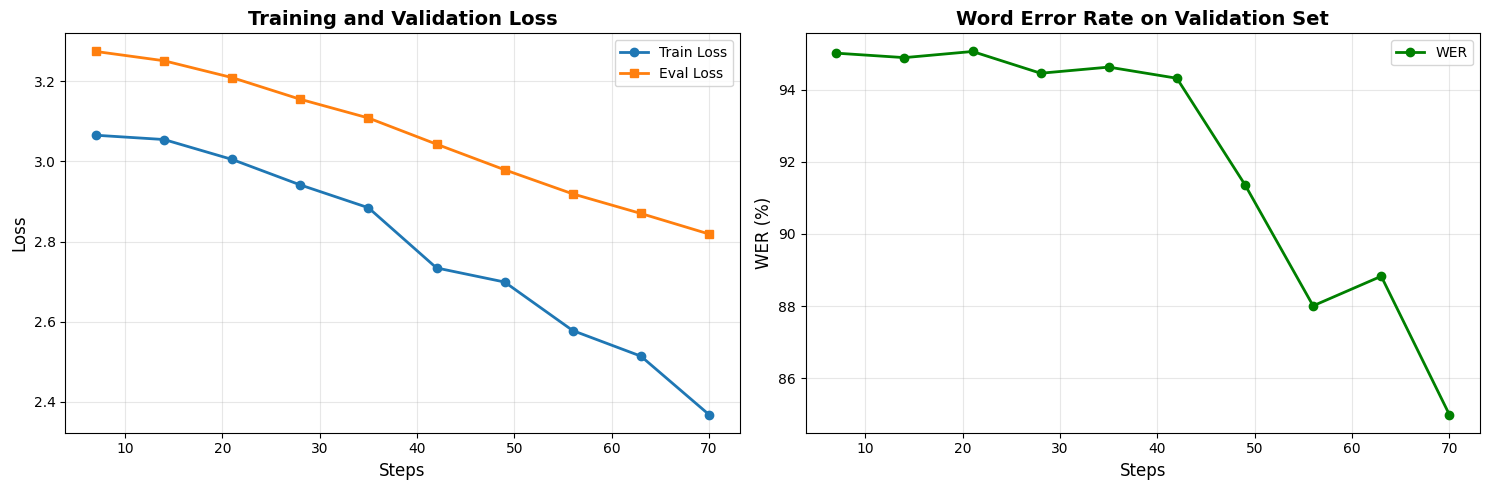


Training curves saved to: /content/drive/MyDrive/whisper_bassa_finetune/training_curves.png


In [ ]:
import matplotlib.pyplot as plt

# Extract training history
logs = trainer.state.log_history

# Separate train and eval logs
train_loss = []
eval_loss = []
train_steps = []
eval_steps = []

for log in logs:
    if "loss" in log:
        train_loss.append(log["loss"])
        train_steps.append(log["step"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
ax1.plot(train_steps, train_loss, label="Train Loss", marker='o', linewidth=2)
ax1.plot(eval_steps, eval_loss, label="Eval Loss", marker='s', linewidth=2)
ax1.set_xlabel("Steps", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12)
ax1.set_title("Training and Validation Loss", fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot WER over time
eval_wer = [log["eval_wer"] for log in logs if "eval_wer" in log]
eval_wer_steps = [log["step"] for log in logs if "eval_wer" in log]

ax2.plot(eval_wer_steps, eval_wer, label="WER", marker='o', color='green', linewidth=2)
ax2.set_xlabel("Steps", fontsize=12)
ax2.set_ylabel("WER (%)", fontsize=12)
ax2.set_title("Word Error Rate on Validation Set", fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/training_curves.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTraining curves saved to: {OUTPUT_DIR}/training_curves.png")

## Evaluation metrics

In [ ]:
train_results = trainer.evaluate(dataset["train"])

print("TRAIN SET RESULTS")
print(f"WER: {train_results['eval_wer']:.2f}%")
print(f"CER: {train_results['eval_cer']:.2f}%")

You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TRAIN SET RESULTS
WER: 77.62%
CER: 63.10%


In [ ]:
test_results = trainer.evaluate(dataset["test"])

print("TEST SET RESULTS")
print(f"WER: {test_results['eval_wer']:.2f}%")
print(f"CER: {test_results['eval_cer']:.2f}%")

You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TEST SET RESULTS
WER: 84.99%
CER: 66.47%
